In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset
from torch import nn
from torchvision.transforms.functional import convert_image_dtype
from scipy.interpolate import CubicSpline
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

In [2]:

# Paths to data
path_kp = "data_files/kp_data.txt"
path_img_specs = "data_files/image_specs.csv"
img_dir = "data_files/solar_images"

# Load kp data
data_kp = pd.read_csv(path_kp)
data_kp["datetime"] = pd.to_datetime(data_kp["datetime"])

# Load image specs data
img_specs = pd.read_csv(path_img_specs)
img_specs["datetime"] = pd.to_datetime(img_specs["datetime"])

image_filenames = img_specs["filename"].values
image_dates = img_specs["datetime"].values


# Converting datetimes to integer timestamps in seconds
image_timestamps = image_dates.astype("int64") // 10**9
kp_timestamps = data_kp["datetime"].values.astype("int64") // 10**9
kp_index_interpolated = CubicSpline(kp_timestamps, data_kp["Kp"].values)(
    image_timestamps
)

data_merged = pd.DataFrame(
    {
        "Timestamp": image_timestamps,
        "Image_filename": image_filenames,
        "Kp": kp_index_interpolated,
    }
)

day = 24 * 60 * 60
year = 365.2425 * day
# Synodic carrington rotation of sun
cycle = 27.2753 * day

data_merged["day_sin"] = np.sin(image_timestamps * (2 * np.pi / day))
data_merged["day_cos"] = np.cos(image_timestamps * (2 * np.pi / day))
data_merged["cycle_sin"] = np.sin(image_timestamps * (2 * np.pi / cycle))
data_merged["cycle_cos"] = np.cos(image_timestamps * (2 * np.pi / cycle))
data_merged["year_sin"] = np.sin(image_timestamps * (2 * np.pi / year))
data_merged["year_cos"] = np.cos(image_timestamps * (2 * np.pi / year))

# Scaling the numerical data
kp_scaler = MinMaxScaler(feature_range=(-1, 1))
timestamp_scaler = MinMaxScaler(feature_range=(-1, 1))

data_merged["Kp"] = kp_scaler.fit_transform(data_merged["Kp"].values.reshape(-1, 1))
data_merged["Timestamp"] = timestamp_scaler.fit_transform(
    data_merged["Timestamp"].values.reshape(-1, 1)
)


def create_sequence(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        feature = data.iloc[i : i + seq_length]
        target = data.iloc[i + seq_length]["Kp"]
        sequences.append((feature, target))
    return sequences


class ImageAndKpDataset(Dataset):
    def __init__(self, sequences, img_dir, img_transform):
        self.sequences = sequences
        self.img_transform = img_transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.sequences)

    def read_and_transform_image(self, path):
        return self.img_transform(read_image(path).cuda().float())

    def __getitem__(self, idx):
        features, target = self.sequences[idx]
        image_paths = [
            os.path.join(self.img_dir, path)
            for path in features["Image_filename"].values
        ]
        features = features.drop(columns=["Image_filename"])
        numerical_features = torch.tensor(features.values, dtype=torch.float32).cuda()
        target = torch.tensor(target, dtype=torch.float32).cuda().unsqueeze(-1)
        with ThreadPoolExecutor() as executor:
            images = list(executor.map(self.read_and_transform_image, image_paths))
        images = torch.stack(images)
        return images, numerical_features, target


seq_length = 7
sequences = create_sequence(data_merged, seq_length)
# img_transform = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
img_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = ImageAndKpDataset(sequences, img_dir, img_transform)

# Split training data into training and validation data:
full_len = len(dataset)
train_frac = 0.25
train_size = int(full_len * train_frac)
train_data = Subset(dataset, range(0, train_size))
val_data = Subset(dataset, range(train_size, full_len))

In [3]:
class SolarImageKpModel(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN for the solar images
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.fc1 = nn.Linear(128 * 128 * 128, 4)
        self.fc1 = nn.Linear(64 * 64 * 128, 4)

        # RNN for the image data
        self.lstm_img = nn.LSTM(
            input_size=4, hidden_size=128, num_layers=1, batch_first=True
        )

        # Fully-connected layers for the numerical data (8 input features)
        self.fc_num1 = nn.Linear(8, 16)
        self.fc_num2 = nn.Linear(16, 128)

        # RNN for the numerical data
        self.lstm_num = nn.LSTM(
            input_size=128, hidden_size=128, num_layers=1, batch_first=True
        )

        # Fully-connected layer that combines the image and numerical data to make the final prediction
        self.fc_final = nn.Linear(256, 1)

    def forward(self, x_img, x_num):
        batch_size, seq_length, _, _, _ = x_img.size()

        # Perform CNN
        cnn_features = []
        for i in range(seq_length):
            img = x_img[:, i, :, :, :]
            img = self.pool(F.relu(self.conv1(img)))
            img = self.pool(F.relu(self.conv2(img)))
            img = self.pool(F.relu(self.conv3(img)))
            img = img.view(batch_size, -1)
            img = F.relu(self.fc1(img))
            cnn_features.append(img)

        # Putting the CNN features together so we can pass them to the RNN
        cnn_features = torch.stack(cnn_features, dim=1)

        rnn_out_img, _ = self.lstm_img(cnn_features)

        # We take the last time step from the RNN
        rnn_out_img = rnn_out_img[:, -1, :]

        # The two fully-connected layers for the numerical features
        x_num = F.relu(self.fc_num1(x_num))
        x_num = F.relu(self.fc_num2(x_num))

        # RNN for the numerical features
        rnn_out_num, _ = self.lstm_num(x_num)
        rnn_out_num = rnn_out_num[:, -1, :]

        # Combining the CNN and numerical features RNN output
        combined_rnn = torch.cat((rnn_out_img, rnn_out_num), dim=1)

        # Final fully-connected layer
        out = self.fc_final(combined_rnn)

        return out


In [5]:
n_seq = 0
num_forecast_steps = 8
model = torch.load("Models/image_largemodel25.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
n_forward = int(full_len * (1-train_frac))
target_arr = []
pred_arr = []
with torch.no_grad():
    for i in tqdm(range(n_forward)):
            img, num_feats, target = val_data[i]
            img, num_feats = img.to(device).unsqueeze(0), num_feats.to(device).unsqueeze(0)
            target = target.item()
            target_arr.append(target)
            pred = model(img, num_feats)
            pred_arr.append(pred.item())
target_arr = np.array(target_arr).reshape(-1, 1)
pred_arr = np.array(pred_arr).reshape(-1, 1)
target_arr = kp_scaler.inverse_transform(target_arr).ravel()
pred_arr = kp_scaler.inverse_transform(pred_arr).ravel()

target_arr_class = (target_arr>=5).astype(int)
pred_arr_class = (pred_arr>=5).astype(int)

100%|████████████████████████████████████████████████████████████████████████████| 30027/30027 [15:55<00:00, 31.42it/s]


In [13]:
n_forward = int(full_len * train_frac)
target_arr_train = []
pred_arr_train = []
with torch.no_grad():
    for i in tqdm(range(n_forward)):
            img, num_feats, target = train_data[i]
            img, num_feats = img.to(device).unsqueeze(0), num_feats.to(device).unsqueeze(0)
            target = target.item()
            target_arr_train.append(target)
            pred = model(img, num_feats)
            pred_arr_train.append(pred.item())
target_arr_train = np.array(target_arr_train).reshape(-1, 1)
pred_arr_train = np.array(pred_arr_train).reshape(-1, 1)
target_arr_train = kp_scaler.inverse_transform(target_arr_train).ravel()
pred_arr_train = kp_scaler.inverse_transform(pred_arr_train).ravel()

target_arr_class_train = (target_arr_train>=5).astype(int)
pred_arr_class_train = (pred_arr_train>=5).astype(int)

100%|████████████████████████████████████████████████████████████████████████████| 10009/10009 [05:19<00:00, 31.32it/s]


In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
import scienceplots
import matplotlib.dates as mdates

In [19]:
score = roc_auc_score(target_arr_class, pred_arr_class)
print(score)

score_train = roc_auc_score(target_arr_class_train, pred_arr_class_train)
print(score_train)

0.6410199538793162
0.825939803147026


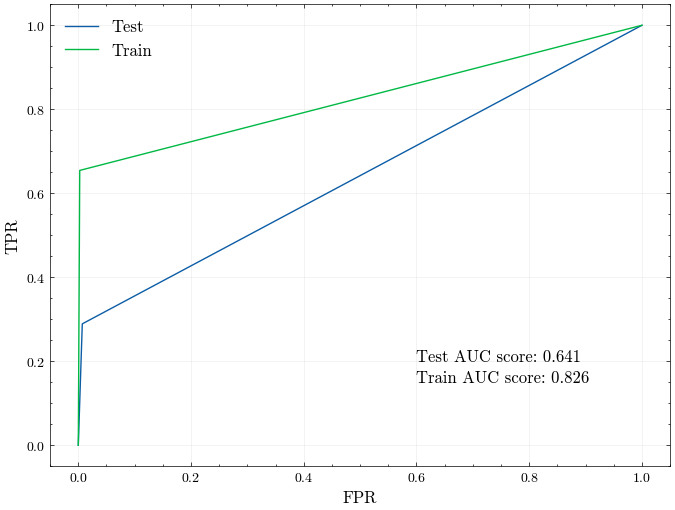

In [31]:
fig = plt.figure(figsize=(8, 6))
plt.style.use(["science", "no-latex"])
fpr, tpr, _ = roc_curve(target_arr_class, pred_arr_class)
fpr_train, tpr_train, _ = roc_curve(target_arr_class_train, pred_arr_class_train)

plt.plot(fpr, tpr, label="Test")
plt.plot(fpr_train, tpr_train, label="Train")
plt.text(0.6, 0.2, "Test AUC score: {}".format(round(score, 3)), fontsize=12)
plt.text(0.6, 0.15, "Train AUC score: {}".format(round(score_train, 3)), fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)
plt.grid(alpha=0.2)
plt.savefig("Plots/25pct_50epoch_largemodel_regression_ROC.png", dpi=200)

In [26]:
date_range

10009   2013-12-31 19:44:12
10010   2013-12-31 22:59:00
10011   2014-01-01 00:14:00
10012   2014-01-01 03:29:00
10013   2014-01-01 06:43:48
                ...        
10104   2014-01-12 16:29:24
10105   2014-01-12 19:44:36
10106   2014-01-12 22:59:12
10107   2014-01-13 00:14:24
10108   2014-01-13 03:29:00
Name: datetime, Length: 100, dtype: datetime64[ns]

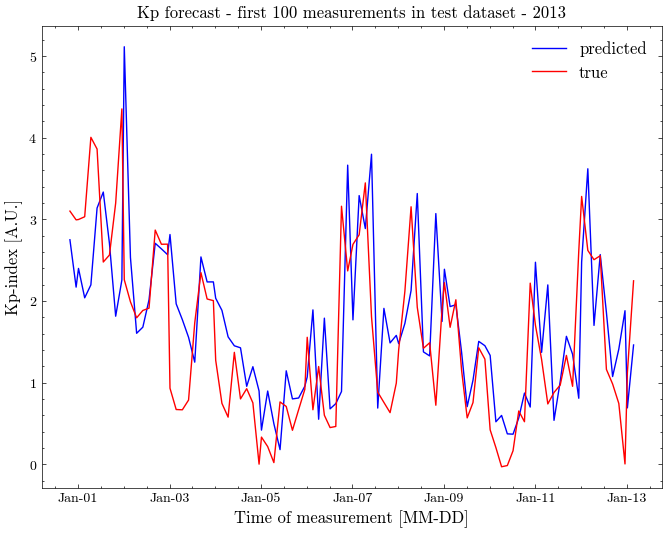

In [35]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
shift_val = 100
date_range = img_specs["datetime"][int(full_len * train_frac):int(full_len * train_frac)+shift_val]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

ax.set_title("Kp forecast - first 100 measurements in test dataset - 2013")
ax.plot(date_range, pred_arr[:shift_val], label="predicted", color="blue")
ax.plot(date_range, target_arr[:shift_val], label="true", color="red")
ax.set_xlabel("Time of measurement [MM-DD]", fontsize=12)
ax.set_ylabel("Kp-index [A.U.]", fontsize=12)
ax.legend(fontsize=12)
plt.savefig("Plots/25pct_50epochs_largemodel_regression_forecast1.png", dpi=200)

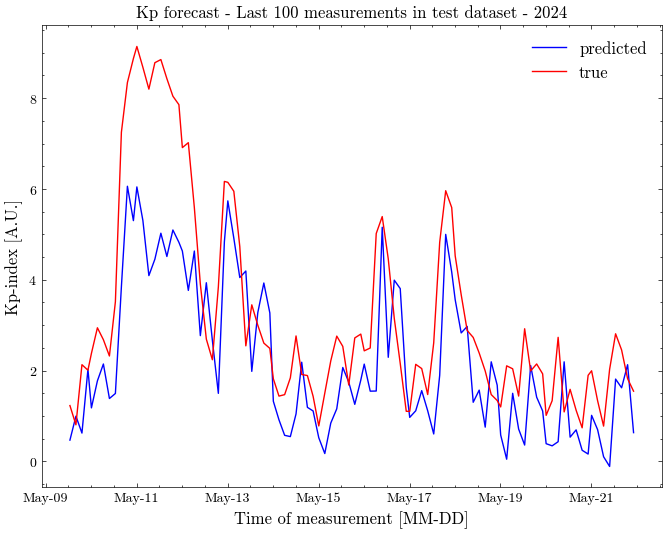

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))
shift_val = 100
date_range = img_specs["datetime"][-shift_val:]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

ax.set_title("Kp forecast - Last 100 measurements in test dataset - 2024")
ax.plot(date_range, pred_arr[-shift_val:], label="predicted", color="blue")
ax.plot(date_range, target_arr[-shift_val:], label="true", color="red")
ax.set_xlabel("Time of measurement [MM-DD]", fontsize=12)
ax.set_ylabel("Kp-index [A.U.]", fontsize=12)
ax.legend(fontsize=12)
plt.savefig("Plots/Appendix/25pct_50epochs_largemodel_regression_forecast2.png", dpi=200)

In [38]:
train_test_history_path = "data_files/25pct_50epochs_batch8"
train_hist = np.genfromtxt(train_test_history_path + "/train_history.csv", delimiter=",", skip_header=1).T

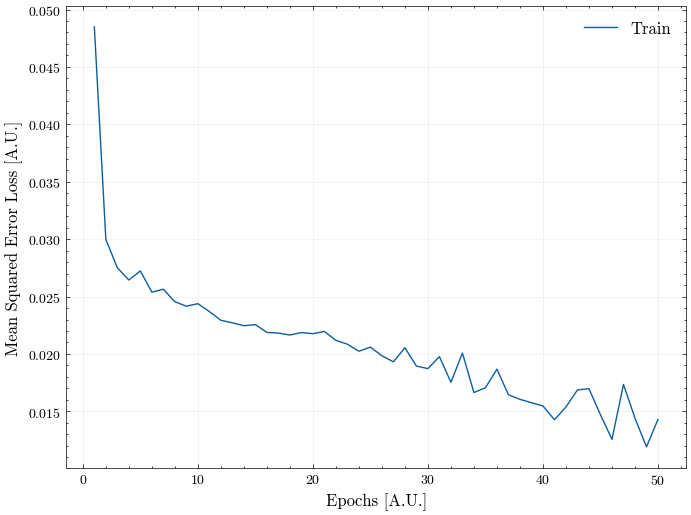

In [40]:
fig = plt.figure(figsize=(8, 6))
plt.plot((train_hist[0]).astype(int)+1, train_hist[1], label="Train")
plt.xlabel("Epochs [A.U.]", fontsize=12)
plt.ylabel("Mean Squared Error Loss [A.U.]", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)
plt.savefig("Plots/25pct_50epochs_regression_train_test_loss.png", dpi=200)

In [17]:
target_arr_storms = []
pred_arr_storms = []
with torch.no_grad():
    for idx, test_seq in tqdm(enumerate(val_data)):
        img, num_feats, target = test_seq
        target = kp_scaler.inverse_transform(target.cpu().numpy().reshape(-1, 1)).flatten()[0]
        if target >= 5:
            img, num_feats = img.to(device).unsqueeze(0), num_feats.to(device).unsqueeze(0)
            pred = model(img, num_feats)
            target_arr_storms.append(target)
            pred_arr_storms.append(pred.item())

30027it [08:27, 59.16it/s]


In [19]:
pred_arr_storms = kp_scaler.inverse_transform(np.array(pred_arr_storms).reshape(-1, 1)).flatten()

[3.45466824 4.09605876 5.67759875 3.84074087 5.14390114 5.37157875
 3.26996408 2.46744029 3.68128033 5.75358337 4.47416645 3.25211545
 3.50098858 7.98887091 4.32076109 4.74840079 3.4568128  5.09694244
 3.73095753 4.76311919 3.09640799 3.25741641 2.39737428 5.42911752
 3.66632223 5.44454148 4.42940525 5.95671553 6.00377466 3.66273291
 5.6695658  1.32570592 7.51491418 4.54482406 5.43266397 2.81973013
 4.01526076 5.05006344 3.36511246 4.54126581 3.45201538 5.09074414
 4.07000582 5.44003281 5.02741049 5.49994116 4.17436489 6.96979658
 3.01460778 5.96046887 5.62663983 5.31844937 4.64791015 4.95696006
 3.82064467 1.5554832  6.96735593 3.91178938 2.69044522 1.66511115
 6.65313335 3.61191024 3.38154783 4.08205712 4.86839012 4.10232209
 6.30903674 4.85008844 3.95897281 3.76438089 6.61575998 4.60573692
 7.32523204 4.91029489 4.83604336 6.34774985 2.49200674 4.49537637
 1.34239652 6.80243304 2.86034623 3.87142318 5.59032305 2.71646866
 4.82377222 6.12433718 4.00088276 5.74051949 4.79797278 4.5602

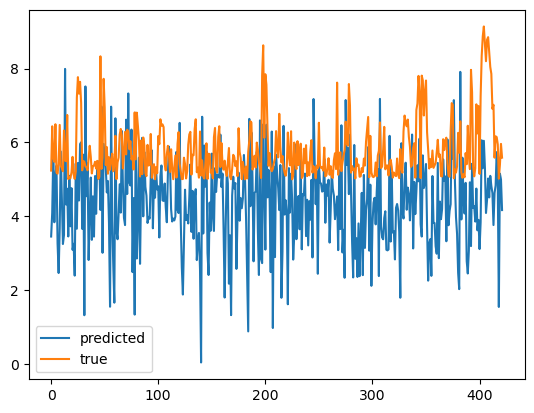

In [22]:
plt.plot(pred_arr_storms, label="predicted")
plt.plot(target_arr_storms, label="true")
plt.legend()

In [23]:
len(pred_arr_storms[pred_arr_storms>=5])/len(target_arr_storms)

0.2890995260663507